In [4]:
# !pip install openseespy opsvis  #required in colab, not required in local environment
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops
import opsvis

In [5]:
# unit 1 of park (Model 1)
# Every dimensions have been converted into mm before proceeding with the analysis, load into kN
mm = 1
kN  = 1
N = kN/1000
m = 1000*mm
MPa = N/mm**2

In [6]:
ops.wipe()
ops.model("Basic","-ndm",2,"-ndf",3)  #model is 2d with three degrees of freedom per node

In [7]:
DBeam = 457*mm  #key
DCol = 406*mm   #key
beamPlasticHingeLength = DBeam/2  #originally divide by 2
# beamPlasticHingeLength = DBeam #originally divide by 2
columnPlasticHingeLength = DCol/2 #originally divide by 2

In [8]:
# Nodes definition
#left beam
#2-200 plastic hinge->heavy section discretization
ops.node(1,0,0)     #center node of the subassembles


# These nodes also have been commented out for external joint 
# ops.node(2,-DCol/4,0)  #left end of the rigid link
# ops.node(200, -DCol/4 - beamPlasticHingeLength,0) #end of plastic hinge


# ops.node(3,-848*mm,0)  #left end of the beam where gravity load is applied
# ops.node(4,-2119*mm,0)  #extreme left end

#right beam
#500-5 plastic hinge->heavy section discretization
ops.node(5,DCol/4,0*mm)  #right rigid link
ops.node(500, +DCol/4 + beamPlasticHingeLength,0) #end of plastic hinge
ops.node(6,848*mm,0*mm)  #right beam where gravity load is applied
ops.node(7,2119*mm,0*mm)  #right extreme beam



#top column 8-800 rigid link
ops.node(8,0,DBeam/4*mm) #column top rigid link
ops.node(800,0,DBeam/4*mm + columnPlasticHingeLength) #column top rigid link
ops.node(9,0,1236*mm) #column top extreme->lateral displacement node

#bottom column
ops.node(10,0,-DBeam/4) #column bottom rigid link
ops.node(1000,0,-DBeam/4-columnPlasticHingeLength) #end of plastic hinge
ops.node(11,0,-1236*mm) #column bottom extreme

In [9]:
# ########################## Here we define the nodes for the columns ##############################
# 1236 is the distance of the extreme end of the column from the beam column joint center
differenceColumn = -DBeam/4-DCol/2 + 1236  #length of the column excluding plastic hinge length and rigid link lengths
numEleCol = 2
lengthEleCol = differenceColumn/numEleCol

[ops.node(51+i, 0, -DBeam/4 - columnPlasticHingeLength - i*lengthEleCol) for i in range(1,numEleCol)]   #for the bottom column

[ops.node(501+i, 0, +DBeam/4 + columnPlasticHingeLength + i*lengthEleCol) for i in range(1,numEleCol)] #for the top column

[None]

In [10]:

# ########################## Here we define the nodes for the beams ##############################
# lengthof the beam on eigher side is 2119 mm from the joint center
differenceBeam1 = -DCol/4 - DBeam/2 + 848 #this is the length of the beam upto the gravity loading point excluding pH length on either side
differenceBeam2 = -848 + 2119 #This is the length of the beam from the gravity load point to the extreme end

numEleBeam1 = 2
numEleBeam2 = 2
lengthEleBeam1 = differenceBeam1/numEleBeam1
lengthEleBeam2 = differenceBeam2/numEleBeam2  #These were used previously to discretize the beam when all the elements were modeled with distributed plasticity
# lengthEleBeam1 is for the elements right next to the plastic hinge zone
# lengthEleBeam3 is for the elements right next to the  nodes with gravity loads


#for the beam to the left of the joint
# The following two beams have been commented because the left beam is to be omitted for an external joint
# let's see if the model runs properly without these two beams

# [ops.node(5001+i, -DCol/4 - beamPlasticHingeLength - i*lengthEleBeam1, 0) for i in range(1,numEleBeam1)]  
# [ops.node(5051+i, -848 - i*lengthEleBeam2, 0) for i in range(1,numEleBeam2)]


#for the beam to the right of the joint
[ops.node(6001+i, +DCol/4 + beamPlasticHingeLength + i*lengthEleBeam1, 0) for i in range(1,numEleBeam1)]  
[ops.node(6051+i, +848 + i*lengthEleBeam2, 0) for i in range(1,numEleBeam2)]


[None]

In [11]:
#here we give section definitions using fiber sections, could have used RCSection2d as well!!
#two different sections have been defined for each columns and beams
#one heavily discretized section for plastic hinge regions and one lightly discretized section for the rest of the member length
# 1->plastic hinge section for beam
# 2->sections other than plastic hinge section for beam
# 3->plastic hinge section for column
# 1->sections other than plastic hinge section for column
transfTag = 1
ops.geomTransf("PDelta",transfTag)
# ops.rigidLink("-beam",1,2)
# ops.rigidLink("-beam",1,8)
# ops.rigidLink("-beam",1,5)
# ops.rigidLink("-beam",1,10)
fck = 39.1
Econc = 5000*np.sqrt(fck) *MPa*0.7  #as per IS 456:2000 code, 0.7 has been multiplied to model the beam column connection with a lower stiffness to match experimental results
# I_rig  = 1e10
# A_rig = 1e10
# ops.element("elasticBeamColumn",100,1,2,A_rig,E_rig,I_rig,transfTag)
# ops.element("elasticBeamColumn",101,1,8,A_rig,E_rig,I_rig,transfTag)
# ops.element("elasticBeamColumn",102,1,5,A_rig,E_rig,I_rig,transfTag)
# ops.element("elasticBeamColumn",103,1,10,A_rig,E_rig,I_rig,transfTag)



secTagBeamAtPlasticHinges = 1
secTagBeam = 2
secTagColumnAtPlasticHinges = 3
secTagColumn = 4

<b><center>Beam Definitions</center></b>

(np.float64(125.95),
 np.float64(-125.95),
 np.float64(-251.35),
 np.float64(251.35))

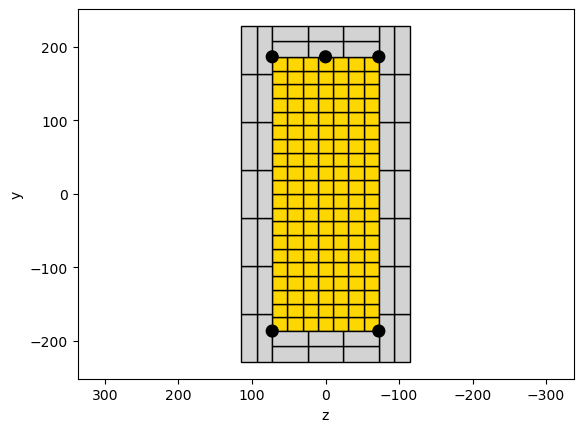

In [12]:

# ################################### For beam:  ##########################
#defining these parameters so that elements outside of the plastic hinge length can be modeled as elastic beam column elements
#These are to be changed while defining sections, hence key parameters for the research work
# Section definitions


Bbeam = 229*mm  #key
Hbeam = 457*mm  #key

#may be i would benefit from using the elastic section for the elastic beam column elements
#  as i have already defined the fiber section layout here
Ibeam = 0.35 * Bbeam*Hbeam**3/12
Abeam = Bbeam*Hbeam
c = 42*mm  # cover  #consistent

y1col = Hbeam/2.0
z1col = Bbeam/2.0
separation_between_bars = 33*mm
y2col = y1col - c - separation_between_bars

nFibZCoverTopBottom = 3
nFibZCoverLeftRight = 2
nFibZCore = 7
nFib = 7
nFibCover, nFibCore = 2, 20
As9 = np.pi*16**2/4  #6 #9 bars for compression and tension face  #key
Fy = 294 * N/mm**2  #done   #key



# uniaxialMaterial('Concrete02', matTag, fpc, epsc0, fpcu, epsU, lambda, ft, Ets)
# ops.uniaxialMaterial("Concrete02", 2, -39*MPa, -0.002,-0.2*39*MPa,-0.004,0.3,2*MPa,3.6e3)  #unconfined concrete
ops.uniaxialMaterial("Concrete02", 2, -39*MPa, -0.002,0*MPa,-0.004,0.3,2*MPa,3.6e3)  #unconfined concrete

# ops.uniaxialMaterial("Concrete02", 3, -48*MPa, -0.003,-0.2*48*MPa,-0.01,0.3,2*MPa,3.6e3)   #confined concrete
ops.uniaxialMaterial("Concrete02", 3, -48*MPa, -0.003,0*MPa,-0.01,0.3,2*MPa,3.6e3)   #confined concrete

# uniaxialMaterial('Steel02', matTag, Fy, E0, b, *params, a1=a2*Fy/E0, a2=1.0, a3=a4*Fy/E0, a4=1.0, sigInit=0.0)
# R0=between 10 and 20, cR1=0.925, cR2=0.15
# D16 Rebar - Beam
# uniaxialMaterial     Steel02     2002     295000000.00000     210000000000.00000     0.00400     20.00000     0.92500     0.15000
fyBeamRebar = 295*MPa
# EBeamRebar =  0.35*210e3*MPa
EBeamRebar =  210e3*MPa
ops.uniaxialMaterial('Steel02', 4, fyBeamRebar,EBeamRebar , 0.004, 20,0.925,0.15) #material for rebar
# ops.uniaxialMaterial("Steel02",3,2500)  #material for unconfined concrete
# ops.uniaxialMaterial("Elastic",3,2500)  #material for confined concrete
# ops.uniaxialMaterial("Elastic",4,2500)   #material for rebar


beamSectionAtPlasticHinges = [['section', 'Fiber', secTagBeamAtPlasticHinges, '-GJ', 1.0e6],
             ['patch', 'rect', 3, nFibCore, nFibZCore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 2, nFib, nFibZCoverLeftRight, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 2, nFib, nFibZCoverLeftRight, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 2, nFibCover, nFibZCoverTopBottom, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 2, nFibCover, nFibZCoverTopBottom, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 4, 3, As9, y1col-c, z1col-c, y1col-c, c-z1col],
            #  ['layer', 'straight', 4, 2, As9, y2col, z1col-c, y2col, c-z1col],
             ['layer', 'straight', 4, 2, As9, c-y1col, z1col-c, c-y1col, c-z1col]]


opsvis.fib_sec_list_to_cmds(beamSectionAtPlasticHinges)

nFibZCoverTopBottom = 3
nFibZCoverLeftRight = 2
nFibZCore = 5
nFib = 5
nFibCover, nFibCore = 2, 4

beamSection = [['section', 'Fiber', secTagBeam, '-GJ', 1.0e6],
             ['patch', 'rect', 2, nFibCore, nFibZCore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 2, nFib, nFibZCoverLeftRight, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 2, nFib, nFibZCoverLeftRight, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 2, nFibCover, nFibZCoverTopBottom, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 2, nFibCover, nFibZCoverTopBottom, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 4, 3, As9, y1col-c, z1col-c, y1col-c, c-z1col],
            #  ['layer', 'straight', 4, 2, As9, y2col, z1col-c, y2col, c-z1col],
             ['layer', 'straight', 4, 2, As9, c-y1col, z1col-c, c-y1col, c-z1col]
             ]


opsvis.fib_sec_list_to_cmds(beamSection)

matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
opsvis.plot_fiber_section(beamSectionAtPlasticHinges, matcolor=matcolor)
plt.axis('equal')


# matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
# opsvis.plot_fiber_section(beamSection, matcolor=matcolor)
# plt.axis('equal')
# plt.show()

<center><b>Column Definitions</b></center>

(np.float64(167.75),
 np.float64(-167.75),
 np.float64(-223.3),
 np.float64(223.3))

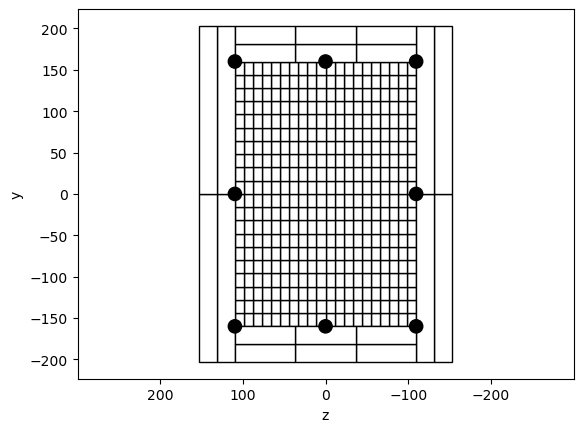

In [13]:
# ############################################## For column: #######################################

#defining these parameters so that elements outside of the plastic hinge length can be modeled as elastic beam column elements
Bcol = 305*mm
Hcol = 406*mm
Icol = 0.7 * Bbeam*Hbeam**3/12
Acol = Bcol*Hcol


# L_RL_beam = Hcol/4
# L_RL_col = Hbeam/4

c = 43*mm  # cover

y1col = Hcol/2.0
z1col = Bcol/2.0

fyColumnRebar = 500*MPa
# fyColumnRebar = 295*MPa
# EColumnRebar = 0.7*210e3*MPa
EColumnRebar = 200e3*MPa

# nFibZ = 1  #do separate discretization for the core and the cover later
# nFib = 20
nFibCover,nFibCover2, nFibCore = 4,2, 16
nFibZCoverTopBottom = 3
nFibZCoverLeftRight = 2
nFibZCore = 7
nFib = 7
nFibCover, nFibCore = 2, 20
# As9 = 1*mm*mm  #four #9 bars cover is 2.5 mmes
# uniaxialMaterial('Concrete02', matTag, fpc, epsc0, fpcu, epsU, lambda, ft, Ets)
ops.uniaxialMaterial("Concrete02", 5, -39*MPa, -0.002,-0.2*39*MPa,-0.004,0.3,2*MPa,3.6e3)  #unconfined concrete
ops.uniaxialMaterial("Concrete02", 6, -48*MPa, -0.003,-0.2*48*MPa,-0.01,0.3,2*MPa,3.6e3)  #confined concrete
# # ops.uniaxialMaterial("Elastic",6,2500)  #material for unconfined concrete
# # ops.uniaxialMaterial("Elastic",7,2500)   #material for rebar
# # ops.uniaxialMaterial('Steel02', 7, fyColumnRebar, EColumnRebar, 0.004, 20,0.925,0.15)
ops.uniaxialMaterial('Steel02', 7, fyColumnRebar, EColumnRebar, 0.004, 20,0.925,0.15) #material for rebar




columnSectionAtPlasticHinges = [['section', 'Fiber', secTagColumnAtPlasticHinges, '-GJ', 1.0e6],
             ['patch', 'rect', 6, nFibCore, nFibCore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 5, nFibCover, nFibZCoverLeftRight, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 5, nFibCover, nFibZCoverLeftRight, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 5, nFibCover2, nFibZCoverTopBottom, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 5, nFibCover2, nFibZCoverTopBottom, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 7, 3, As9, y1col-c, z1col-c, y1col-c, c-z1col],
             ['layer', 'straight', 7, 2, As9, 0, z1col-c, 0, c-z1col],
             ['layer', 'straight', 7, 3, As9, c-y1col, z1col-c, c-y1col, c-z1col]]


opsvis.fib_sec_list_to_cmds(columnSectionAtPlasticHinges)

#column section at places other than plastic hinges
nFibCover,nFibCover2, nFibCore = 4,2, 8 #at sections other than plastic hinges
columnSection = [['section', 'Fiber', secTagColumn, '-GJ', 1.0e6],
             ['patch', 'rect', 6, nFibCore, nFibCore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 5, nFibCover, nFibZCoverLeftRight, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 5, nFibCover, nFibZCoverLeftRight, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 5, nFibCover2, nFibZCoverTopBottom, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 5, nFibCover2, nFibZCoverTopBottom, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 7, 3, As9, y1col-c, z1col-c, y1col-c, c-z1col],
             ['layer', 'straight', 7, 2, As9, 0, z1col-c, 0, c-z1col],
             ['layer', 'straight', 7, 3, As9, c-y1col, z1col-c, c-y1col, c-z1col]]


opsvis.fib_sec_list_to_cmds(columnSection)


matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
opsvis.plot_fiber_section(columnSectionAtPlasticHinges, matcolor=matcolor)
plt.axis('equal')

# matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
# opsvis.plot_fiber_section(columnSection, matcolor=matcolor)
# plt.axis('equal')

# matcolor = ['r', 'lightgrey', 'gold', 'w', 'lightgrey', 'gold','w']
# opsvis.plot_fiber_section(columnSection, matcolor=matcolor)
# plt.axis('equal')

# # element('elasticBeamColumn', eleTag, *eleNodes, secTag, transfTag, <'-mass', mass>, <'-cMass'>, <'-release', releaseCode>)
# # ops.element("elasticBeamColumn",1,1,2,secTagColumn,transfTag)
# # ops.element("elasticBeamColumn",2,2,3,secTagColumn,transfTag)
# # ops.element("elasticBeamColumn",3,2,4,secTagBeam,transfTag)

<b><center> Integration schemes have been defined for the plastic hinge elements </center></b>

In [14]:
# here we define the beam integration rules for the different elements
# by default integration points are set to be 5 for each element
#could be taken higher for elements in the plastic hinge regions
integrationTagBeamPlasticHinges = 1
integrationTagBeam = 2

integrationTagColumn = 3
integrationTagColumnPlasticHinges = 4

# # beamIntegration('Lobatto', tag, secTag, N)
ops.beamIntegration("Lobatto",integrationTagBeamPlasticHinges, secTagBeamAtPlasticHinges, 5)
ops.beamIntegration("Lobatto",integrationTagBeam, secTagBeam, 5)

ops.beamIntegration("Lobatto",integrationTagColumnPlasticHinges,secTagColumnAtPlasticHinges, 5)
ops.beamIntegration("Lobatto",integrationTagColumn,secTagColumn, 5)

<b><center> beam column elements with element labels 1,9,4 and 7 to be defined below are the plastic hinge elements! </center></b>

In [15]:
# This section is commented because the left beam is to be omitted for an external joint
# #################### left beam of the plastic hinge region#############
# # # ops.element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-iter', maxIter=10, tol=1e-12, '-mass', mass=0.0)
# ops.element("dispBeamColumn", 1, *[200,2], transfTag, integrationTagBeamPlasticHinges) #left beam plastic hinge region

# # first beam to the left of the plastic hinge region for the left beam which is to be omitted for an external joint
# # this lump of code you see is because the first and last elements connect different nodes that don't fit into a pattern and 
# # the middle ones connect the consecutive nodes, for example, for first beam on the left outside of the ph connects node 200 to node 5002
# # and the last connects the final node in the pattern to the gravity loading node 3, here 5002 to 3

# for i in range(1,numEleBeam1+1):
#   if i == 1:
#     # ops.element('dispBeamColumn',5000+i,*[5002,200],transfTag, integrationTagBeam)
#     ops.element("elasticBeamColumn",5000+i,*[5002,200],Abeam,Econc,Ibeam,transfTag )
#   elif i== numEleBeam1:
#     # ops.element('dispBeamColumn',5000+i,*[3,5000+i],transfTag, integrationTagBeam)
#     ops.element("elasticBeamColumn",5000+i,*[3,5000+i],Abeam,Econc,Ibeam,transfTag)  #first and last elements have different initial and final nodes that don't fit into a pattern
#   else:
#     # ops.element('dispBeamColumn', 5000+i, *[5000+i+1,5000+i], transfTag, integrationTagBeam) #first beam to the left
#     ops.element("elasticBeamColumn", 5000+i, *[5000+i+1,5000+i], Abeam,Econc,Ibeam,transfTag) #first beam to the left outside of the plastic hinge region
# # ops.element('dispBeamColumn', 2, *[3,200], transfTag, integrationTagBeam) #beam
# # ops.element('dispBeamColumn', 3, *[4,3], transfTag, integrationTagBeam) #beam

# # Down this are the beam elements to the left of the gravity loading point on the left side

# for i in range(1,numEleBeam2+1):
#   if i == 1:
#     # ops.element('dispBeamColumn',5050+i,*[5052,3],transfTag, integrationTagBeam)
#     ops.element("elasticBeamColumn",5050+i,*[5052,3],Abeam,Econc,Ibeam,transfTag)
#   elif i== numEleBeam2:
#     # ops.element('dispBeamColumn',5050+i,*[4,5050+i],transfTag, integrationTagBeam)
#     ops.element("elasticBeamColumn",5050+i,*[4,5050+i],Abeam,Econc,Ibeam,transfTag)
#   else:
#     # ops.element('dispBeamColumn', 5050+i, *[5050+i+1,5050+i], transfTag, integrationTagBeam) #first beam to the left
#     ops.element("elasticBeamColumn", 5050+i, *[5050+i+1,5050+i],Abeam,Econc,Ibeam,transfTag) #first beam to the left
# # ops.element('dispBeamColumn', 2, *[3,200], transfTag, integrationTagBeam) #beam
# # ops.element('dispBeamColumn', 3, *[4,3], transfTag, integrationTagBeam) #beam


In [16]:
#################### right beam of the plastic hinge region#############
ops.element("dispBeamColumn", 4, *[5,500], transfTag, integrationTagBeamPlasticHinges) #right beam
# ops.element('dispBeamColumn', 4, *[5,500], transfTag, integrationTagBeamPlasticHinges) #right beam
for i in range(1,numEleBeam1+1):
  if i == 1:
    ops.element('dispBeamColumn',6000+i,*[500,6002],transfTag, integrationTagBeam)
    # ops.element("elasticBeamColumn",6000+i,*[500,6002],Abeam,Econc,Ibeam,transfTag)
  elif i== numEleBeam1:
    ops.element('dispBeamColumn',6000+i,*[6000+i,6],transfTag, integrationTagBeam)
    # ops.element("elasticBeamColumn",6000+i,*[6000+i,6],Abeam,Econc,Ibeam,transfTag)
  else:
    ops.element('dispBeamColumn', 6000+i, *[6000+i,6000+i+1], transfTag, integrationTagBeam) #first beam to the right till the gravity load point
    # ops.element("elasticBeamColumn",6000+i,*[6000+i,6000+i+1],Abeam,Econc,Ibeam,transfTag)
# ops.element('dispBeamColumn', 2, *[3,200], transfTag, integrationTagBeam) #beam
# ops.element('dispBeamColumn', 3, *[4,3], transfTag, integrationTagBeam) #beam


# Down this are the beam elements to the right of the gravity loading point on the right side

for i in range(1,numEleBeam2+1):
  if i == 1:
    ops.element('dispBeamColumn',6050+i,*[6,6052],transfTag, integrationTagBeam)
    # ops.element("elasticBeamColumn",6050+i,*[6,6052],Abeam,Econc,Ibeam,transfTag)
  elif i== numEleBeam2:
    ops.element('dispBeamColumn',6050+i,*[6050+i,7],transfTag, integrationTagBeam)
    # ops.element("elasticBeamColumn",6050+i,*[6050+i,7],Abeam,Econc,Ibeam,transfTag)
  else:
    ops.element('dispBeamColumn', 6050+i, *[6050+i,6050+i+1], transfTag, integrationTagBeam) #beam to the right of the gravity load point
    # ops.element("elasticBeamColumn",6050+i,*[6050+i,6050+i+1],Abeam,Econc,Ibeam,transfTag)
# ops.element('dispBeamColumn', 2, *[3,200], transfTag, integrationTagBeam) #beam
# ops.element('dispBeamColumn', 3, *[4,3], transfTag, integrationTagBeam) #beam

In [17]:
#bottom columns for the beam column joint
# ops.element('dispBeamColumn', 4, *[5,500], transfTag, integrationTagBeamPlasticHinges) #right beam
# ops.element('dispBeamColumn', 5, *[500,6], transfTag, integrationTagBeam) #beam
# ops.element('dispBeamColumn', 6, *[6,7], transfTag, integrationTagBeam) #beam
ops.element('dispBeamColumn', 7, *[10,1000], transfTag, integrationTagColumnPlasticHinges)  #bottom column
for i in range(1,numEleCol+1):
  if i == 1:
    ops.element('dispBeamColumn',50+i,*[1000,52],transfTag, integrationTagColumn)
  elif i== numEleCol:
    ops.element('dispBeamColumn',50+i,*[50+i,11],transfTag, integrationTagColumn)
  else:
    ops.element('dispBeamColumn', 50+i, *[50+i,50+i+1], transfTag, integrationTagColumn)  #bottom column
# ops.element('dispBeamColumn', 8, *[1000,11], transfTag, integrationTagColumn)  #bottom column

In [18]:
# top columns for the beam column joint
ops.element('dispBeamColumn', 9, *[8,800], transfTag, integrationTagColumnPlasticHinges)  #top column
for i in range(1,numEleCol+1):
  if i == 1:
    ops.element('dispBeamColumn',500+i,*[800,502],transfTag, integrationTagColumn)
  elif i== numEleCol:
    ops.element('dispBeamColumn',500+i,*[500+i,9],transfTag, integrationTagColumn)
  else:
    ops.element('dispBeamColumn', 500+i, *[500+i,500+i+1], transfTag, integrationTagColumn)  #top column

# element('dispBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-cMass', '-mass', mass=0.0)

In [19]:
#define the fixities for the points
# ops.fix(4,0,1,0) #left extreme end of the beam commented out for external joint
ops.fix(7,0,1,0)
# ops.fix(9,0,1,0)
ops.fix(11,1,1,0)
# [{eleTag: ops.eleNodes(eleTag)} for eleTag in ops.getEleTags() if eleTag >6000 and eleTag<7000]

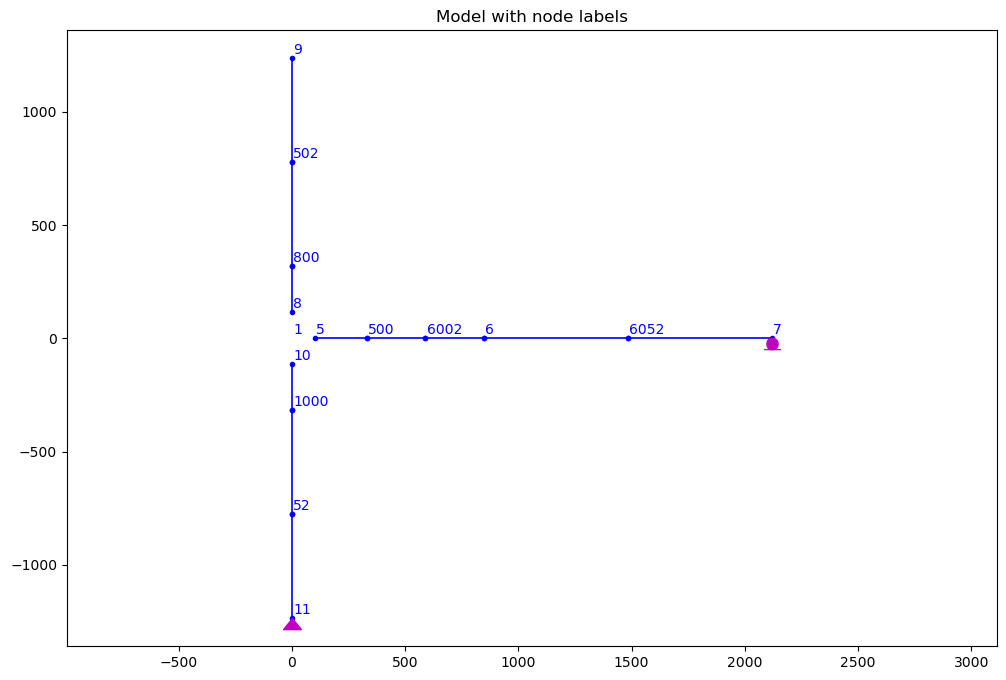

In [20]:
# opsvis.plot_model(node_labels = False, gauss_points = False)
# model is plotted with node labels and, element labels and gauss_points are hidden for clarity
opsvis.plot_model(element_labels = False, gauss_points = False)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.title("Model with node labels")
plt.show()

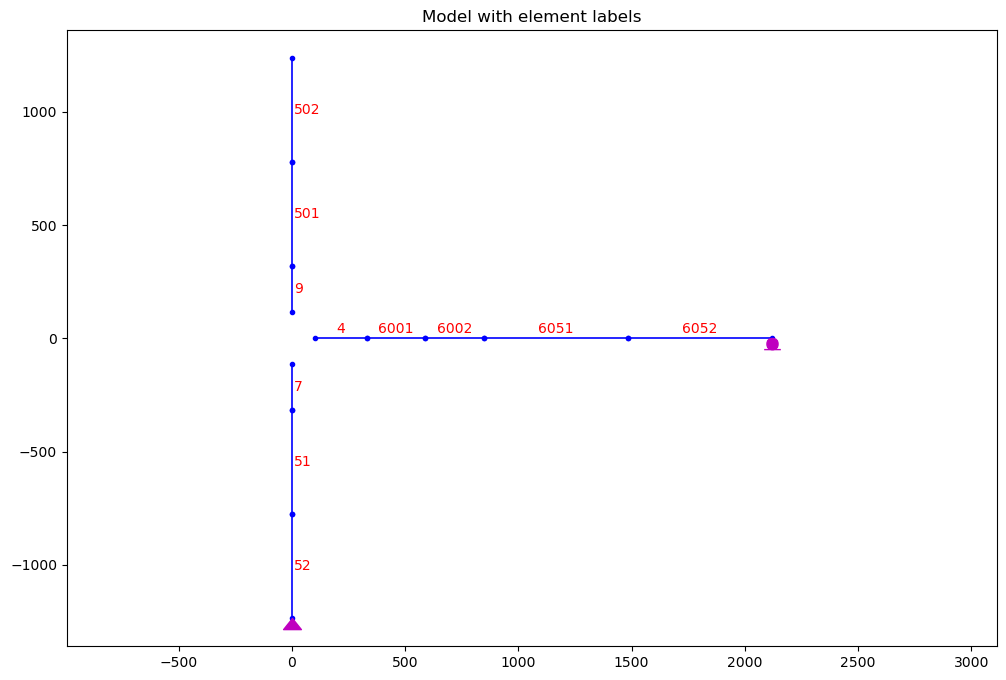

In [21]:
# opsvis.plot_model(node_labels = False, gauss_points = False)
# model is plotted with element labels and, node labels and gauss_points are hidden for clarity
opsvis.plot_model(node_labels = False, gauss_points = False)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.title("Model with element labels")
plt.show()

In [22]:
# 8,5,2,10 are the rigid link nodes connected to the neighboring plastic hinge elements
# define the rigid links
ops.rigidLink("-beam",1,8)
ops.rigidLink("-beam",1,5)
ops.rigidLink("-beam",1,10)
# ops.rigidLink("-beam",1,2) #commented out for external joint because this falls in the left branch which is omitted

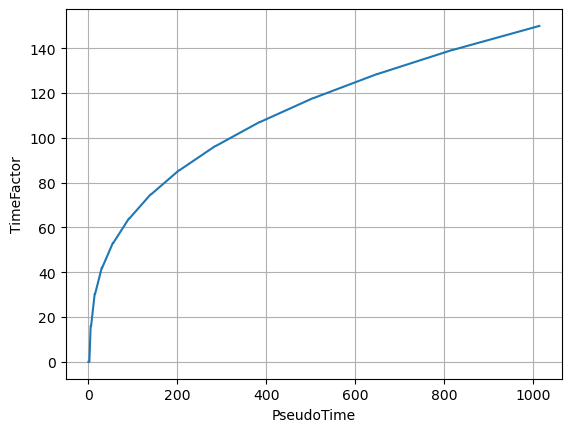

In [23]:
NN = 2
def defineTimeFactorHistory1(peaksArray,scaleFactor,nSteps,nCycles):
    timeFactor = []
    for j,thisPeak in enumerate(peaksArray):
        for i in range(nCycles):
            timeFactor = np.append(timeFactor,np.linspace(0,thisPeak*scaleFactor,nSteps*j**3))
            timeFactor = np.append(timeFactor,np.linspace(thisPeak*scaleFactor,-thisPeak*scaleFactor,nSteps*j**3))
            timeFactor = np.append(timeFactor,np.linspace(-thisPeak*scaleFactor,0,nSteps*j**3))
def defineTimeFactorHistoryMonotonic(peaksArray,scaleFactor,nSteps,nCycles):
    timeFactor = [0]
    for j,thisPeak in enumerate(peaksArray):
        timeFactor = np.append(timeFactor,np.linspace(timeFactor[-1],thisPeak*scaleFactor,nSteps*j**NN,endpoint  = False))
            # timeFactor = np.append(timeFactor,np.linspace(thisPeak*scaleFactor,-thisPeak*scaleFactor,nSteps*j**3))
            # timeFactor = np.append(timeFactor,np.linspace(-thisPeak*scaleFactor,0,nSteps*j**3))
    plt.plot(timeFactor)
    plt.grid()
    plt.xlabel('PseudoTime')
    plt.ylabel('TimeFactor')
    plt.show()
    return timeFactor
# def defineTimeFactorHistoryMonotonic(peaksArray, scaleFactor, nSteps, nCycles, NN=1):
#     timeFactor = [0.0]
#     for j, thisPeak in enumerate(peaksArray, start=1):
#         nPts = int(nSteps * j**NN)
#         start = timeFactor[-1]
#         end = thisPeak * scaleFactor
#         newSegment = np.linspace(start, end, nPts, endpoint=False)
#         timeFactor = np.append(timeFactor, newSegment)

#     plt.plot(timeFactor)
#     plt.grid(True)
#     plt.xlabel('PseudoTime')
#     plt.ylabel('TimeFactor')
#     plt.show()

#     return timeFactor

def defineTimeFactorHistory(peaksArray,scaleFactor,nSteps,nCycles):
    timeFactor = []
    for j,thisPeak in enumerate(peaksArray):
        for i in range(nCycles):
            timeFactor = np.append(timeFactor,np.linspace(0,thisPeak*scaleFactor,nSteps))
            timeFactor = np.append(timeFactor,np.linspace(thisPeak*scaleFactor,-thisPeak*scaleFactor,nSteps))
            timeFactor = np.append(timeFactor,np.linspace(-thisPeak*scaleFactor,0,nSteps))

    plt.plot(timeFactor)
    plt.grid()
    plt.xlabel('PseudoTime')
    plt.ylabel('TimeFactor')
    plt.show()
    return timeFactor


# peaksArray=np.array([11.11,29.6,44.4,59.2,74.0,88.8,103.6,]) #in mm
peaksArray=np.linspace(0,150,15,endpoint=True) #in mm  set this to 0,300,30 for plastic hinge length of D/2
# peaksArray=np.linspace(0,300,30,endpoint=True) #in mm  set this to 0,300,30 for plastic hinge length of D/2
scaleFactor = 1.0
nSteps = 1
nCycles = 1
timeFactorHistory=defineTimeFactorHistoryMonotonic(peaksArray,scaleFactor,nSteps,nCycles)


The freeEndDisp has been equal to -0.0014044055141088601 at the load of -1.8062588365790468e-19.
The freeEndDisp has been equal to 5.355738451628748 at the load of 13.813426700705795.
The freeEndDisp has been equal to 10.712881308771605 at the load of 21.9082403467987.
The freeEndDisp has been equal to 16.07002416591446 at the load of 21.43104722740361.
The freeEndDisp has been equal to 16.07002416591446 at the load of 21.43104722546628.
The freeEndDisp has been equal to 17.855738451628746 at the load of 21.58912553164138.
The freeEndDisp has been equal to 19.64145273734303 at the load of 21.74532539454267.
The freeEndDisp has been equal to 21.42716702305732 at the load of 21.898653953675883.
The freeEndDisp has been equal to 23.212881308771603 at the load of 22.047274145498843.
The freeEndDisp has been equal to 24.998595594485888 at the load of 22.19462124267347.
The freeEndDisp has been equal to 26.784309880200176 at the load of 22.338834276822077.
The freeEndDisp has been equal to 2

after: 100 iterations  current Norm: 1957.1 (max: 1e-08, Norm deltaR: 1.0539e+06)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -297.099
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 1957.1 (max: 1e-07, Norm deltaR: 1.0539e+06)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -297.099
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 1957.1 (max: 1e-06, Norm deltaR: 1.0539e+06)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor -297.099
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 1957.1 (max: 1e-05, Norm de

The freeEndDisp has been equal to 34.261988451628746 at the load of 22.90628813732574.
The freeEndDisp has been equal to 35.043238451628746 at the load of 22.959345596398048.
The freeEndDisp has been equal to 35.824488451628746 at the load of 23.014427872321097.
The freeEndDisp has been equal to 36.605738451628746 at the load of 23.054160233538344.
The freeEndDisp has been equal to 37.386988451628746 at the load of 23.10790149076014.
The freeEndDisp has been equal to 38.168238451628746 at the load of 23.16089887823963.
The freeEndDisp has been equal to 38.949488451628746 at the load of 23.213140957725233.
The freeEndDisp has been equal to 39.730738451628746 at the load of 23.264615981556922.
The freeEndDisp has been equal to 40.511988451628746 at the load of 23.315309879537686.
The freeEndDisp has been equal to 41.293238451628746 at the load of 23.365191768146385.
The freeEndDisp has been equal to 42.074488451628746 at the load of 23.414250086060584.
The freeEndDisp has been equal to 4

after: 100 iterations  current Norm: 0.00016087 (max: 1e-08, Norm deltaR: 211.904)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 24.2596
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.00016087 (max: 1e-07, Norm deltaR: 211.904)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 24.2596
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.00016087 (max: 1e-06, Norm deltaR: 211.904)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 24.2596
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 5.05411e-05 (max: 1e-08, No

The freeEndDisp has been equal to 83.66176647109546 at the load of 24.29307512632866.
The freeEndDisp has been equal to 83.83269270756847 at the load of 23.802256506982303.
The freeEndDisp has been equal to 84.00361894404148 at the load of 23.830175603074068.
The freeEndDisp has been equal to 84.1745451805145 at the load of 23.852791942421025.
The freeEndDisp has been equal to 84.34547141698751 at the load of 23.87866776454426.
The freeEndDisp has been equal to 84.51639765346052 at the load of 23.907599678000192.
The freeEndDisp has been equal to 84.68732388993352 at the load of 23.933041948229523.
The freeEndDisp has been equal to 84.85825012640655 at the load of 23.95842572382365.
The freeEndDisp has been equal to 85.02917636287955 at the load of 23.983750805454633.
The freeEndDisp has been equal to 85.20010259935256 at the load of 24.009017003091632.
The freeEndDisp has been equal to 85.37102883582557 at the load of 24.034224155773334.
The freeEndDisp has been equal to 85.5419550722

after: 100 iterations  current Norm: 4.19904e-06 (max: 1e-08, Norm deltaR: 8.81492)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 25.3332
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 4.19904e-06 (max: 1e-07, Norm deltaR: 8.81492)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 25.3332
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 4.19904e-06 (max: 1e-06, Norm deltaR: 8.81492)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 25.3332
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 3.29332e-05 (max: 1e-08,

The freeEndDisp has been equal to 113.11518524078528 at the load of 25.336794578225103.
The freeEndDisp has been equal to 113.20462964098988 at the load of 25.316962054074704.
The freeEndDisp has been equal to 113.29407404119446 at the load of 25.329288975606115.
The freeEndDisp has been equal to 113.38351844139906 at the load of 25.338613695067.
The freeEndDisp has been equal to 113.47296284160365 at the load of 25.34212482828905.
The freeEndDisp has been equal to 113.56240724180824 at the load of 25.345635640903232.
The freeEndDisp has been equal to 113.65185164201284 at the load of 25.349146143410223.
The freeEndDisp has been equal to 113.74129604221743 at the load of 25.352656335309767.
The freeEndDisp has been equal to 113.83074044242203 at the load of 25.356160037326916.
The freeEndDisp has been equal to 113.92018484262663 at the load of 25.35962065552613.
The freeEndDisp has been equal to 114.00962924283121 at the load of 25.36312900266553.
The freeEndDisp has been equal to 114.

after: 100 iterations  current Norm: 2.67896e-06 (max: 1e-08, Norm deltaR: 0.592867)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 25.4415
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 2.67896e-06 (max: 1e-07, Norm deltaR: 0.592867)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 25.4415
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 2.67896e-06 (max: 1e-06, Norm deltaR: 0.592867)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 25.4415
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 1.01941e-05 (max: 1e-

The freeEndDisp has been equal to 117.84131995499699 at the load of 25.497812669781542.
The freeEndDisp has been equal to 117.91634585856984 at the load of 25.500614754563284.
The freeEndDisp has been equal to 117.99137176214269 at the load of 25.503416520454735.
The freeEndDisp has been equal to 118.06639766571554 at the load of 25.50621796906859.
The freeEndDisp has been equal to 118.14142356928839 at the load of 25.509019099912003.
The freeEndDisp has been equal to 118.21644947286124 at the load of 25.511819912490655.
The freeEndDisp has been equal to 118.29147537643408 at the load of 25.51462040630895.
The freeEndDisp has been equal to 118.36650128000693 at the load of 25.517420579401747.
The freeEndDisp has been equal to 118.44152718357978 at the load of 25.520220432084425.
The freeEndDisp has been equal to 118.51655308715263 at the load of 25.523019964513793.
The freeEndDisp has been equal to 118.59157899072548 at the load of 25.525819176081804.
The freeEndDisp has been equal to 

after: 100 iterations  current Norm: 0.000434974 (max: 1e-08, Norm deltaR: 23.7115)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 26.3917
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.000434974 (max: 1e-07, Norm deltaR: 23.7115)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 26.3917
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 0.000434974 (max: 1e-06, Norm deltaR: 23.7115)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 26.3917
OpenSees > analyze failed, returned: -3 error flag
after: 100 iterations  current Norm: 1.78101e-05 (max: 1e-08,

The freeEndDisp has been equal to 143.9496463218577 at the load of 26.420087018887067.
The freeEndDisp has been equal to 144.0046367697907 at the load of 26.42198248056107.
The freeEndDisp has been equal to 144.0596272177237 at the load of 26.423891144288895.
The freeEndDisp has been equal to 144.11461766565665 at the load of 26.425799559497413.
The freeEndDisp has been equal to 144.16960811358965 at the load of 26.427707732488887.
The freeEndDisp has been equal to 144.22459856152264 at the load of 26.4296156629207.
The freeEndDisp has been equal to 144.2795890094556 at the load of 26.431523350449712.
The freeEndDisp has been equal to 144.3345794573886 at the load of 26.43343079473192.
The freeEndDisp has been equal to 144.38956990532157 at the load of 26.43533799542254.
The freeEndDisp has been equal to 144.44456035325456 at the load of 26.437244952176425.
The freeEndDisp has been equal to 144.49955080118755 at the load of 26.439151664647213.
The freeEndDisp has been equal to 144.5545

after: 100 iterations  current Norm: 5.63047e-05 (max: 1e-07, Norm deltaR: 20.6082)
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 26.4867
OpenSees > analyze failed, returned: -3 error flag


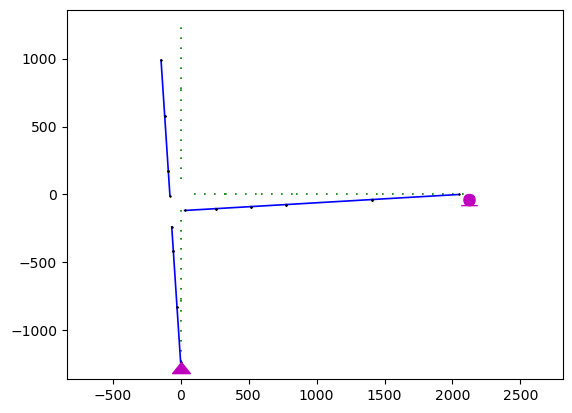

In [24]:
ops.timeSeries("Linear",10)
ops.pattern("Plain",10,10)
# ops.load(3,0,-55*kN,0) #comment out because it falls in the left branch which is omitted for external joint
# ops.load(6,0,-55*kN,0)  #this load lies in the right branch of the beam column joint

ops.load(9,0,-5*kN,0)

ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("BandGeneral")
initialTolerance = 1e-8
ops.test("NormDispIncr",initialTolerance,100)
# integrator('DisplacementControl', nodeTag, dof, incr, numIter=1, dUmin=incr, dUmax=incr)
ops.integrator("LoadControl",0.1)
ops.algorithm("Newton")
ops.analysis("Static")
ok = ops.analyze(10)
ops.loadConst('-time', 0.0)
ops.wipeAnalysis()
ops.setTime(0.0)
opsvis.plot_defo()

ops.timeSeries("Linear",1)  #Displacement control
ops.pattern("Plain",1,1)
ops.load(9,1,0,0)

# recorder('Element', '-file', filename, '-xml', filename, '-binary', filename, '-precision', nSD=6, '-timeSeries', tsTag, '-time', '-dT', deltaT=0.0, '-closeOnWrite', '-ele', *eleTags=[], '-eleRange', startEle, endEle, '-region', regionTag, *args)
# ops.recorder('Element', '-file', f"MomentCurvature_plasticHingeLength:{beamPlasticHingeLength/DBeam}.out", '-timeSeries', 1, '-time', '-ele', [5001,1], "section","force")
# ops.recorder('Element', '-file', f"Moment_plasticHingeLength:{beamPlasticHingeLength/DBeam}.out", '-time', '-ele', 1, "section","Force")
# ops.recorder('Element', '-file', f"Curvature_plasticHingeLength:{beamPlasticHingeLength/DBeam}.out", '-time', '-ele', 1, "section","deformation")


ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("UmfPack")
initialTolerance = 1e-8 #initially 1e-8
ops.test("NormDispIncr",initialTolerance,100)
initialDisplacementIncrement  = timeFactorHistory[1] - timeFactorHistory[0]
# integrator('DisplacementControl', nodeTag, dof, incr, numIter=1, dUmin=incr, dUmax=incr)
ops.integrator("DisplacementControl",9,1,initialDisplacementIncrement,100)  #load to be applied at the tip of the beam free end
ops.algorithm("KrylovNewton")
ops.analysis("Static")
freeEndDisp = [ops.nodeDisp(9,1)]
loadFactor = [ops.getLoadFactor(1)]

ok = ops.analyze(1)
n = 1

freeEndDisp.append(ops.nodeDisp(9,1))
loadFactor.append(ops.getLoadFactor(1))

noOfAttempt = 0
while ok==0 and n<len(timeFactorHistory)-1:
# while ok==0 and n<20:

  displacementIncrement = timeFactorHistory[n+1] - timeFactorHistory[n]
  # print(displacementIncrement)
  ops.integrator("DisplacementControl",9,1,displacementIncrement,100)
  ok = ops.analyze(1)
  modifiedTolerance = initialTolerance*10
  noOfAttempt = 0
  while ok!=0 and noOfAttempt < 8: #initially 4 set to 6
    ops.test("NormDispIncr",modifiedTolerance,100)
    ok = ops.analyze(1)
    modifiedTolerance = modifiedTolerance*10
    noOfAttempt+=1
  if ok!=0:
    break
  ops.test("NormDispIncr",initialTolerance,100)
  freeEndDisp.append(ops.nodeDisp(9,1))
  print(f"The freeEndDisp has been equal to {ops.nodeDisp(9,1)} at the load of {ops.getLoadFactor(1)}.")
  loadFactor.append(ops.getLoadFactor(1))
  n+=1

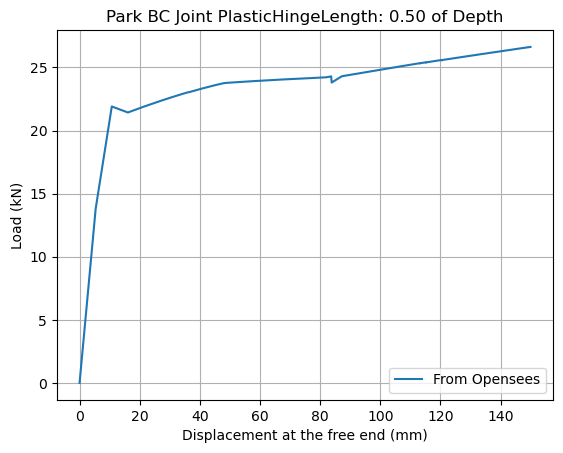

In [25]:
enveloperight = np.loadtxt(f"envelopeRightPark.txt")
# plt.plot(enveloperight[:,1],enveloperight[:,0],'black', marker = "o",markersize = 7, linewidth = 3,ls = "--", label = "Backbone Curve")
# plt.plot(leftEnvelope[1,:],leftEnvelope[0,:],'black', marker = 'o',markersize = 7,linewidth = 3,ls = "--",)
loadFactor = np.array(loadFactor)
# loadFactor = loadFactor - loadFactor[0]
freeEndDisp = np.array(freeEndDisp)
# freeEndDisp = freeEndDisp - freeEndDisp[0]
plt.plot(freeEndDisp,loadFactor,label = "From Opensees")
plt.ylabel("Load (kN)")
plt.xlabel("Displacement at the free end (mm)")
plt.grid()
plt.legend(loc = "lower right")
# plt.title("Park BC Joint")
# from google.colab import files
plt.title(f"Park BC Joint PlasticHingeLength: {beamPlasticHingeLength/DBeam:.2f} of Depth")
# plt.savefig(f"Park BC Joint PlasticHingeLength: {beamPlasticHingeLength/DBeam:.2f} of Depth.png")

# 3. Download the file
# files.download(f"Park BC Joint PlasticHingeLength: {beamPlasticHingeLength/DBeam:.2f} of Depth.png")
plt.show()

In [26]:
maxDisp,maxLoad = freeEndDisp[np.where(loadFactor==np.max(loadFactor))[0][0]], np.max(loadFactor)
maxDisp, maxLoad #these are the values to be returned by the program #key

(np.float64(149.9436051465529), np.float64(26.626578243131842))

In [27]:
id = np.where(loadFactor==np.max(loadFactor))[0][0]
loadFactor[id],loadFactor[-1]

(np.float64(26.626578243131842), np.float64(26.626578243131842))

In [28]:
# I will track the first point from which the load deformation curve starts to fall down, that will be the point of maximum load, rest is ignored
maxLoad = loadFactor[np.where(np.diff(loadFactor)<0)[0][0]+1]
maxDisp = freeEndDisp[np.where(np.diff(loadFactor)<0)[0][0]+1]
maxDisp, maxLoad

(np.float64(-0.0014044055141088601), np.float64(-1.8062588365790468e-19))

In [29]:
np.where(loadFactor==np.max(loadFactor))[0][0]

np.int64(1015)

np.float64(149.945009552067)

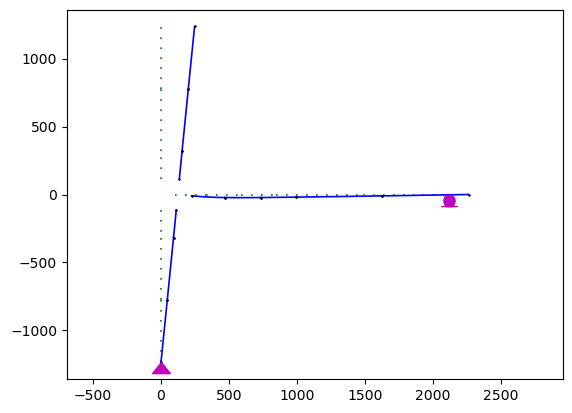

In [30]:
opsvis.plot_defo()
# print(loadFactor[0])
timeFactorHistory[-1]

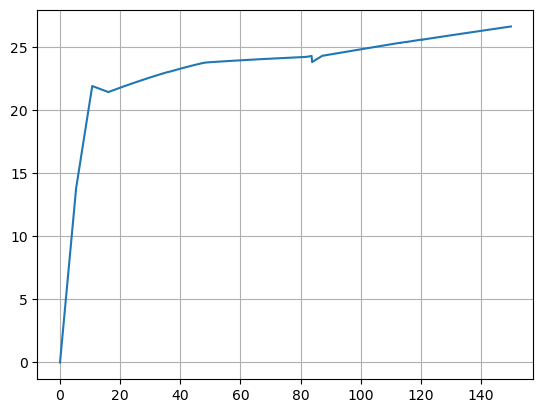

In [31]:
plt.plot(freeEndDisp,loadFactor)
plt.grid()

In [32]:
data = ops.eleResponse(1,"section",1,"fiberData")
y = data[0:len(data):5]
z = data[1:len(data):5]
A = data[2:len(data):5]
sig = data[3:len(data):5]
strain = data[4:len(data):5]

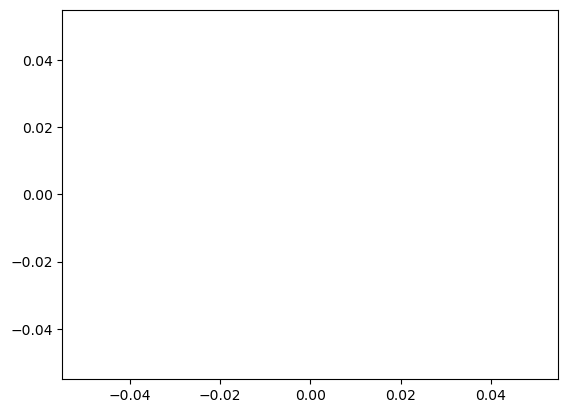

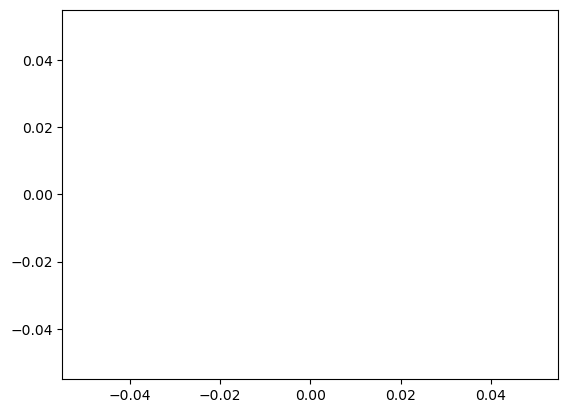

In [33]:
plt.scatter(y,np.array(sig)*1000)
plt.show()
plt.scatter(y,np.array(strain))

0.07176954732510288